#*Tarea #5*

###*Por Simón Patiño Idarraga*

##Instalamos los paquetes requeridos:

In [ ]:
!pip install -Uq pymcel sgp4
!pip install -Uq montu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.4/682.4 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.6 MB/s eta 0:00:00


Importamos lo que necesitamos para nuestros cálculos:

In [ ]:
from sgp4.io import twoline2rv
from sgp4.earth_gravity import wgs84
import numpy as np
import matplotlib.pyplot as plt
import pymcel as pc
from astropy.time import Time
import spiceypy as spy
import montu as mn

deg = np.pi/180
rad = 180/np.pi

Paquete pymcel cargado. Versión: 0.5.12
Running MontuPython version 0.9.6


In [ ]:
pc.descarga_kernels()

spy.furnsh(['pymcel/data/latest_leapseconds.tls'])

Creando el directorio con los kernels pymcel//data/...
Descargando kernel 'de430.bsp' en 'pymcel/'...
Hecho.
Descargando kernel 'de430_tech-comments.txt' en 'pymcel/'...
Hecho.
Descargando kernel 'latest_leapseconds.tls' en 'pymcel/'...
Hecho.
Descargando kernel 'naif0012.tls' en 'pymcel/'...
Hecho.
Descargando kernel 'earth_latest_high_prec.bpc' en 'pymcel/'...
Hecho.
Descargando kernel 'earth_fixed.tf' en 'pymcel/'...
Hecho.
Descargando kernel 'gm_de431.tpc' en 'pymcel/'...
Hecho.
Descargando kernel 'pck00011.tpc' en 'pymcel/'...
Hecho.


##Vamos primero a obtener los elementos orbitales a partir del TLE de la ISS (TLE extraido el domingo 5 de mayo a las 11.56am, tiempo local)

In [ ]:
%%file TLE.txt
1 25544U 98067A   24126.54229730  .00012115  00000-0  21296-3 0  9990
2 25544  51.6365 166.8420 0003436 138.5313 221.5938 15.50916801451933

Writing TLE.txt


##A continuación toda la rutina propuesta por el profesor para calcular el azimut y la elevación de la ISS.

##El código calculara la posición de la ISS cada hora y verificara dos condiciones:


*   ¿Su elevación es positiva en las coordenadas especificadas?
*   ¿Son las 6,7 o 8 pm?

##Si ambas condiciones se cumplen, el código devolverá el azimut y la elevación, el tiempo inicial donde se empezó el cálculo y el tiempo donde se verá la ISS de noche.

In [ ]:
f = open('TLE.txt','r')
lines = f.readlines()
linea1 = lines[0]
linea2 = lines[1]

satelite = twoline2rv(linea1,linea2,wgs84)

# Elementos primarios
a = satelite.a*satelite.radiusearthkm
e = satelite.em
I = satelite.im
Omega = satelite.Om
omega = satelite.om
Mo = satelite.mm

# Información adicional
mu = satelite.mu
n = np.sqrt(mu*1e9/(a*1e3)**3)
tini = satelite.jdsatepoch

tini, a, e, I*rad, Omega*rad, omega*rad, Mo*rad, n*rad

b = a*np.sqrt(1-e**2)
p = a*(1-e**2)
h = np.sqrt(mu*p)

t = tini

horizontal_elements = [0,-1]

lat_sitio = 6.1246042408678845
lon_sitio = -75.37607669765796
alt_sitio = 2.125

while (horizontal_elements[1] < 0 or (Time(t,format='jd').iso[11:13] != "18" and
                                       Time(t,format='jd').iso[11:13] != "19" and
                                       Time(t,format='jd').iso[11:13] != "20") ):  #while elevation is negative, calculate position
                                                                                   #while time is different to night, calculate position

  t= t + 0.041666 #iterate each hour

  M = Mo + n*(t-tini)*86400 ; M = np.mod(M,2*np.pi)
  E, error, niter = pc.kepler_newton(M,e,M,delta=1e-12) ; E = np.mod(E,2*np.pi)
  f = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2)) ; f = np.mod(f,2*np.pi)

  xppp = a*np.cos(E)
  yppp = b*np.sin(E)
  zppp = 0

  vxppp = -mu/h*np.sin(f)
  vyppp = mu/h*(e+np.cos(f))
  vzppp = 0

  Minv = spy.eul2m(-Omega,-I,-omega,3,1,3)

  rvec = spy.mxv(Minv,[xppp,yppp,zppp])
  vvec = spy.mxv(Minv,[vxppp,vyppp,vzppp])

  rvec, vvec, np.linalg.norm(rvec)

  r, teta, lon = spy.recsph(rvec)
  declinacion = np.pi/2 - teta
  ascension_recta = np.mod(lon,2*np.pi)

  posicion_observacion_ejesfijos = spy.georec(lon_sitio*deg,lat_sitio*deg,alt_sitio,6371,0)
  posicion_observacion_ejesfijos

  et = spy.utc2et(Time(t,format='jd').iso)
  Mrot = spy.pxform('IAU_EARTH','J2000',et)
  posicion_observacion_estrellas = spy.mxv(Mrot,posicion_observacion_ejesfijos)
  posicion_observacion_estrellas

  rvec_sitio = rvec - posicion_observacion_estrellas

  r, teta, lon = spy.recsph(rvec_sitio)
  declinacion = np.pi/2 - teta
  ascension_recta = np.mod(lon,2*np.pi)

  mtime = mn.Time(t,format='jd',scale='utc')
  sitio = mn.Observer(lon=lon_sitio,lat=lat_sitio,height=alt_sitio)

  horizontal_elements = mn.Util.where_in_sky(RA=ascension_recta*rad,Dec=declinacion*rad,
                      at=mtime,observer=sitio)

horizontal_elements,Time(tini,format = "jd").iso ,Time(t,format='jd').iso

((300.3188700011419, 50.806601883361864),
 '2024-05-05 13:00:54.487',
 '2024-05-05 18:00:54.199')

#Segun N2YO, a las 8:24pm pasara la ISS (tiempo local, 5 Mayo). El codigo propone  las 2024-05-05 18:00:54.199 en estandar ISO para este evento. Este codigo no tiene en cuenta la magnitud (visibilidad)




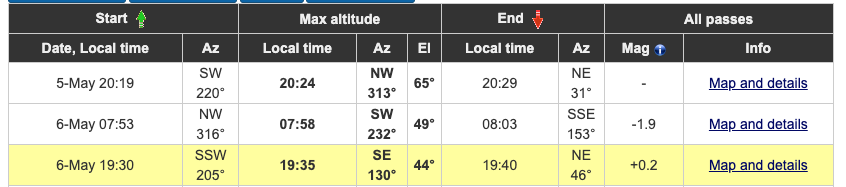

## Un mapa del cielo

Para hacer un mapa del cielo, necesitamos primero cargar las estrellas más brillantes:

In [ ]:
# Cargamos todas las estrellas
todas_las_estrellas = mn.Stars()

# Escogemos solo las estrellas más brillantes
estrellas_brillantes = todas_las_estrellas.get_stars(Vmag=[-2,4])
len(estrellas_brillantes.data)

523

La información sobre las estrellas está en un DataFrame de pandas:

In [ ]:
estrellas_brillantes.data.head(2)

,MN,HD,HR,HIP,Gl,Name,OtherDesignations,ProperName,Bayer,Flamsteed,...,XJ2000,YJ2000,ZJ2000,VXJ2000,VYJ2000,VZJ2000,Primary,MultipleID,IsMultiple,IsVariable
1,2,48915,2491,32349,Gl 244A,Sirius,9 CMa/9Alp CMa/Gl 244A/HD 48915/HIP 32349/HR 2...,Sirius,α CMa,9 CMa,...,-0.494323,2.476731,-0.758485,-0.000012,-0.000012,0.000010,32263,Gl 244,1,1
2,3,45348,2326,30438,NaN,Canopus,Alp Car/Canopus/HD 45348/HIP 30438/HR 2326/HYG...,Canopus,α Car,NaN,...,-5.992679,57.132034,-75.396105,-0.000010,0.000021,-0.000011,30365,NaN,0,1


Ahora necesitamos calcular para ellas sus posiciones, azimut y altura, para la fecha y el lugar elegido:

In [ ]:
estrellas_brillantes.where_in_sky(at=mtime,observer=sitio,inplace=True)

Vamos a hacer un mapa del cielo con las estrellas visibles sobre el horizonte:

In [ ]:
# Seleccionamos solo las estrellas que están sobre el horizonte
estrellas_visibles = estrellas_brillantes.get_stars(el=[0,90])
len(estrellas_visibles.data)

245

El mapa del cielo se puede hacer usando coordenadas polares, donde las coordenadas son el azimut de la estrella y el angulo cenital, que es 90 menos la elevación. El mapa se hace así

##*La ISS se graficará con un punto azul, el tamaño del punto no corresponde con su magnitud*

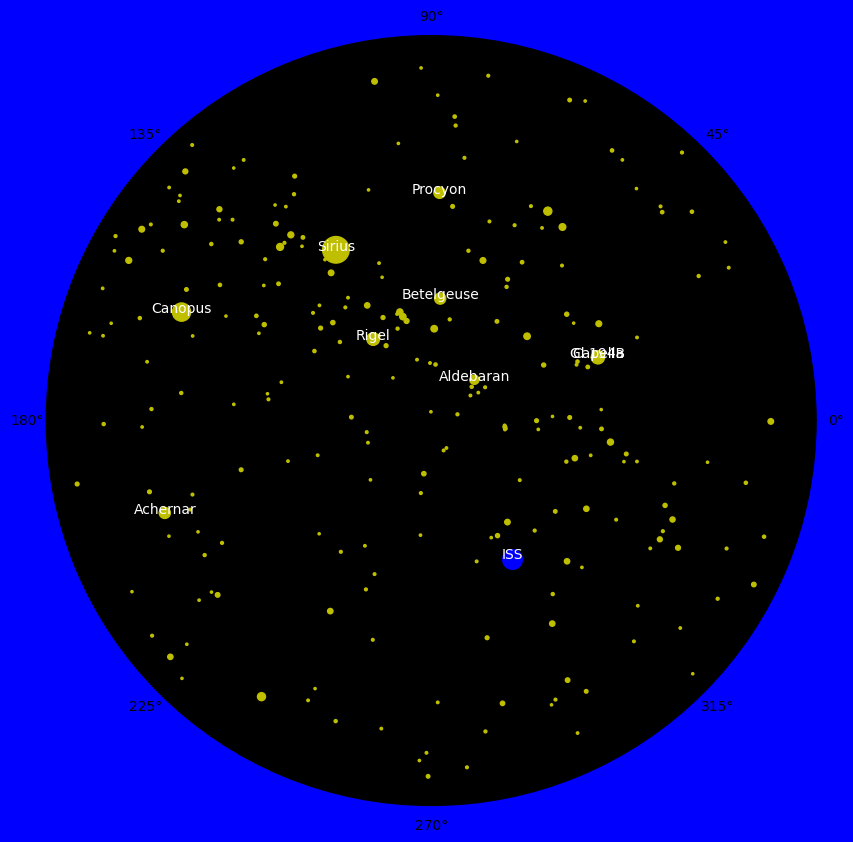

In [ ]:
fig,axs = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection='polar'),
                       facecolor='b')
axs.set_facecolor('black')
axs.grid(alpha=0)
axs.set_yticks([])

# Muestra las estrellas
axs.scatter(estrellas_visibles.data.az*deg,(90-estrellas_visibles.data.el)*deg,
            #color='y',s=30*10**(-estrellas_visibles.data.Vmag))
            color='y',s=2.5**(-estrellas_visibles.data.Vmag+5))

axs.scatter(horizontal_elements[0]*deg,(90-horizontal_elements[1])*deg,
            #color='y',s=30*10**(-estrellas_visibles.data.Vmag))
            color='b',s=200)

axs.text(horizontal_elements[0]*deg,(90-horizontal_elements[1])*deg,"ISS",
           color='w',fontsize=10,ha='center')

# Mostramos el nombre de las estrellas
for _,estrella in estrellas_visibles.data.iterrows():

  # No ponga el nombre de las estrellas más débiles
  if estrella.Vmag>1:continue

  axs.text(estrella.az*deg,(90-estrella.el)*deg,estrella.Name,
           color='w',fontsize=10,ha='center')

#*Trayectoria hasta que sea visible en el horario establecido*

In [ ]:
f = open('TLE.txt','r')
lines = f.readlines()
linea1 = lines[0]
linea2 = lines[1]

satelite = twoline2rv(linea1,linea2,wgs84)

# Elementos primarios
a = satelite.a*satelite.radiusearthkm
e = satelite.em
I = satelite.im
Omega = satelite.Om
omega = satelite.om
Mo = satelite.mm

# Información adicional
mu = satelite.mu
n = np.sqrt(mu*1e9/(a*1e3)**3)
tini = satelite.jdsatepoch

tini, a, e, I*rad, Omega*rad, omega*rad, Mo*rad, n*rad

b = a*np.sqrt(1-e**2)
p = a*(1-e**2)
h = np.sqrt(mu*p)

t = tini

horizontal_elements = [[0,-1]]

lat_sitio = 6.1246042408678845
lon_sitio = -75.37607669765796
alt_sitio = 2.125

while (horizontal_elements[-1][1] < 0 or (Time(t,format='jd').iso[11:13] != "18" and
                                       Time(t,format='jd').iso[11:13] != "19" and
                                       Time(t,format='jd').iso[11:13] != "20") ):  #while elevation is negative, calculate position
                                                                                   #while time is different to night, calculate position

  t= t + 0.000005 #iterate each hour

  M = Mo + n*(t-tini)*86400 ; M = np.mod(M,2*np.pi)
  E, error, niter = pc.kepler_newton(M,e,M,delta=1e-12) ; E = np.mod(E,2*np.pi)
  f = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2)) ; f = np.mod(f,2*np.pi)

  xppp = a*np.cos(E)
  yppp = b*np.sin(E)
  zppp = 0

  vxppp = -mu/h*np.sin(f)
  vyppp = mu/h*(e+np.cos(f))
  vzppp = 0

  Minv = spy.eul2m(-Omega,-I,-omega,3,1,3)

  rvec = spy.mxv(Minv,[xppp,yppp,zppp])
  vvec = spy.mxv(Minv,[vxppp,vyppp,vzppp])

  rvec, vvec, np.linalg.norm(rvec)

  r, teta, lon = spy.recsph(rvec)
  declinacion = np.pi/2 - teta
  ascension_recta = np.mod(lon,2*np.pi)

  posicion_observacion_ejesfijos = spy.georec(lon_sitio*deg,lat_sitio*deg,alt_sitio,6371,0)
  posicion_observacion_ejesfijos

  et = spy.utc2et(Time(t,format='jd').iso)
  Mrot = spy.pxform('IAU_EARTH','J2000',et)
  posicion_observacion_estrellas = spy.mxv(Mrot,posicion_observacion_ejesfijos)
  posicion_observacion_estrellas

  rvec_sitio = rvec - posicion_observacion_estrellas

  r, teta, lon = spy.recsph(rvec_sitio)
  declinacion = np.pi/2 - teta
  ascension_recta = np.mod(lon,2*np.pi)

  mtime = mn.Time(t,format='jd',scale='utc')
  sitio = mn.Observer(lon=lon_sitio,lat=lat_sitio,height=alt_sitio)

  horizontal_elements.append(mn.Util.where_in_sky(RA=ascension_recta*rad,Dec=declinacion*rad,
                      at=mtime,observer=sitio))

horizontal_elements[-1],Time(tini,format = "jd").iso ,Time(t,format='jd').iso

((292.4903563269533, 20.000759950378516),
 '2024-05-05 13:00:54.487',
 '2024-05-05 18:00:00.364')

In [ ]:
first = np.array([t[0] for t in horizontal_elements])

second = np.array([t[1] for t in horizontal_elements])

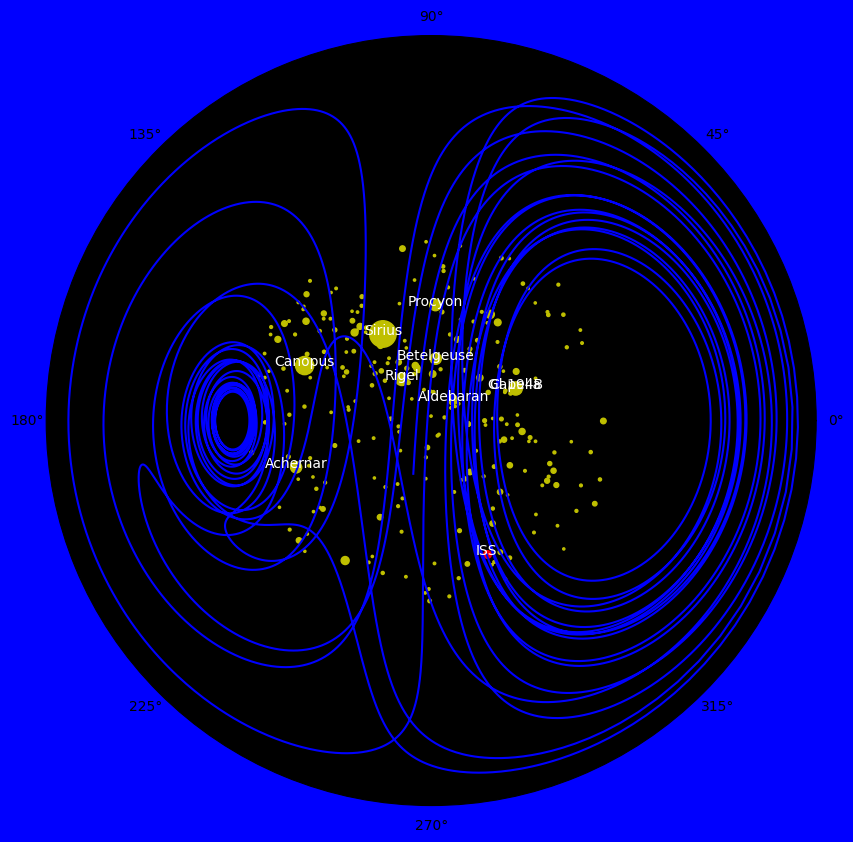

In [ ]:
fig,axs = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection='polar'),
                       facecolor='b')
axs.set_facecolor('black')
axs.grid(alpha=0)
axs.set_yticks([])

# Muestra las estrellas
axs.scatter(estrellas_visibles.data.az*deg,(90-estrellas_visibles.data.el)*deg,
            #color='y',s=30*10**(-estrellas_visibles.data.Vmag))
            color='y',s=2.5**(-estrellas_visibles.data.Vmag+5))

axs.plot(first[1:]*deg,(90-second[1:])*deg,
            #color='y',s=30*10**(-estrellas_visibles.data.Vmag))
            color='b')

axs.scatter(first[-1]*deg,(90-second[-1])*deg,
            #color='y',s=30*10**(-estrellas_visibles.data.Vmag))
            color='r',s = 30)



axs.text(horizontal_elements[-1][0]*deg,(90-horizontal_elements[-1][1])*deg,"ISS",
           color='w',fontsize=10,ha='center')

# Mostramos el nombre de las estrellas
for _,estrella in estrellas_visibles.data.iterrows():

  # No ponga el nombre de las estrellas más débiles
  if estrella.Vmag>1:continue

  axs.text(estrella.az*deg,(90-estrella.el)*deg,estrella.Name,
           color='w',fontsize=10,ha='center')